# PROYECTO FINAL

# CURSO: REDES NEURONALES Y APRENDIZAJE PROFUNDO (MIA-203)

# PROFESOR: ALDO CAMARGO

# TEMA: SISTEMA DE IDENTIFICACION DE MEDIDAS CORPORALES A TRAVÉS DE IMAGENES USANDO CNN

#Grupo #2:
#Integrantes:
#- Benitez Altamirano, Bernie Hans
#- Diaz Cabrera, Alexander Gabriel
#- Morales Ccasa, Geyson David
#- Ramirez Ucañay, Barbarita Paula Janeth
#- Aldo Daniel Siu Siu Ting

##Paso #1: Activar virtual memory para correr codigo con alta capacidad de memoria RAM

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


##Paso #2: Importar y activar librerias

In [10]:
!pip install tensorflow
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab.patches import cv2_imshow  # Importa cv2_imshow desde google.colab.patches
from PIL import Image
from skimage import io  # Importar la función io de skimage
from sklearn.metrics import mean_absolute_error, mean_squared_error

##Paso #3: Conectar a base de datos en Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Paso #4: Ver estructura de datos

In [3]:
# Ruta del directorio raíz
base_path = "/content/drive/MyDrive/BodyM_dataset"

# Ver estructura de directorios (sin incluir imagenes)
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}- {}'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            if not f.endswith('.png'):
                print('{}- {}'.format(subindent, f))

# Llamar a la función para listar los archivos y directorios
list_files(base_path)

- BodyM_dataset
    - train
        - subject_to_photo_map.csv
        - hwg_metadata.csv
        - measurements.csv
        - combined_data.csv
        - train_combined_data.csv
        - mask
        - mask_left
    - testB
        - subject_to_photo_map.csv
        - hwg_metadata.csv
        - measurements.csv
        - combined_data.csv
        - testB_combined_data.csv
        - mask
        - mask_left
    - testA
        - subject_to_photo_map.csv
        - hwg_metadata.csv
        - measurements.csv
        - combined_data.csv
        - testA_combined_data.csv
        - mask
        - mask_left


In [4]:
# Definir la ruta a la carpeta 'train' que contiene los archivos .csv
train_folder_path = '/content/drive/MyDrive/BodyM_dataset/train'
csv_files = [
    'subject_to_photo_map.csv',
    'hwg_metadata.csv',
    'measurements.csv',
]

# Leer y mostrar las primeras 5 filas de cada archivo .csv
for file in csv_files:
    file_path = os.path.join(train_folder_path, file)
    try:
        df = pd.read_csv(file_path)
        print(f"\nFirst 5 rows of {file}:")
        display(df.head(5))
    except Exception as e:
        print(f"Error loading {file}: {e}")


First 5 rows of subject_to_photo_map.csv:


,subject_id,photo_id
0,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,e6f404ebda41ebe93573d3e219c88297
1,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,39a4241cb892618a694747e224d57b9e
2,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,a00a6c0c074efbd92c894cbc77023939
3,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,7c99b3017f21f9797851e70de084bfcb
4,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,3000cb26b2090db5a7d82926af8c6a83



First 5 rows of hwg_metadata.csv:


,subject_id,gender,height_cm,weight_kg
0,AhfyGaD1BKo0-u6PeQk2oI-Bw5l0XxpAqNroFuZuy0I,female,160.00,92.4
1,E8tDQ5IgdBwbjLIXu7GwcupEHYbi0eB18YNcsgsSbP8,female,175.75,102.8
2,59bc2767681516389ccf45f9,male,174.80,106.9
3,nRatvgqbYTN77typTgGm4bAurxzpvf5nYg2Mb3gdh8c,male,181.50,111.8
4,fkq68ww6bdyKT16FavI1x_G-u7YZ9SoT1GNMUTSJUek,female,161.60,93.0



First 5 rows of measurements.csv:


,subject_id,ankle,arm-length,bicep,calf,chest,forearm,height,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist
0,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,24.343954,52.902378,33.294395,38.709511,102.526024,27.599094,177.610992,108.047134,81.736435,35.915691,67.891273,57.872795,92.286171,16.709131
1,-5OHO2b5mRDY1rvAf07sYYtekEEX7ViEGmvRr7l4tfc,22.001783,46.763233,28.288971,35.649963,99.253395,24.813375,164.379623,92.128685,75.127258,33.848778,60.541386,52.418320,87.307899,15.192038
2,-5iHTazqnmWBsnUY6ymoCw1kORMymRDaUla1eNOjgvI,26.565006,53.288597,30.800959,39.854950,102.391273,27.719795,183.718842,106.044121,84.055527,37.856457,72.004379,52.934086,96.596413,17.936598
3,-60o95b9oEE83BDV3GpsAVPA4TFvxuPPqtXEY5PApy8,24.779566,49.077751,34.613113,38.104267,111.164070,28.550409,169.059113,109.529465,74.310234,38.197800,68.536713,58.656673,103.395119,17.029860
4,-67TrwlJ3GSsqPeHaa2Nb0iQ-BKZfIx4ERysQPZ0-SY,20.788853,42.229557,24.527142,29.181356,93.627777,21.979038,146.516632,87.134102,67.269859,31.659197,52.697277,41.844944,74.400856,15.120061


In [5]:
# Base directory
base_dir = '/content/drive/MyDrive/BodyM_dataset'

# Train data paths
train_dir = f'{base_dir}/train'
train_subject_to_photo_map = f'{train_dir}/subject_to_photo_map.csv'
train_hwg_metadata = f'{train_dir}/hwg_metadata.csv'
train_measurements = f'{train_dir}/measurements.csv'
train_mask_dir = f'{train_dir}/mask'
train_mask_left_dir = f'{train_dir}/mask_left'

# TestA data paths
testA_dir = f'{base_dir}/testA'
testA_subject_to_photo_map = f'{testA_dir}/subject_to_photo_map.csv'
testA_hwg_metadata = f'{testA_dir}/hwg_metadata.csv'
testA_measurements = f'{testA_dir}/measurements.csv'
testA_mask_dir = f'{testA_dir}/mask'
testA_mask_left_dir = f'{testA_dir}/mask_left'

# TestB data paths
testB_dir = f'{base_dir}/testB'
testB_subject_to_photo_map = f'{testB_dir}/subject_to_photo_map.csv'
testB_hwg_metadata = f'{testB_dir}/hwg_metadata.csv'
testB_measurements = f'{testB_dir}/measurements.csv'
testB_mask_dir = f'{testB_dir}/mask'
testB_mask_left_dir = f'{testB_dir}/mask_left'

In [6]:
# Load train data CSVs
train_subject_to_photo_df = pd.read_csv(train_subject_to_photo_map)
train_hwg_metadata_df = pd.read_csv(train_hwg_metadata)
train_measurements_df = pd.read_csv(train_measurements)

# Load testA data CSVs
testA_subject_to_photo_df = pd.read_csv(testA_subject_to_photo_map)
testA_hwg_metadata_df = pd.read_csv(testA_hwg_metadata)
testA_measurements_df = pd.read_csv(testA_measurements)

# Load testB data CSVs
testB_subject_to_photo_df = pd.read_csv(testB_subject_to_photo_map)
testB_hwg_metadata_df = pd.read_csv(testB_hwg_metadata)
testB_measurements_df = pd.read_csv(testB_measurements)

In [7]:
# Merge data on 'subject_id' to get photo_id, height, weight, and body measurements in one DataFrame
train_data = train_subject_to_photo_df.merge(train_hwg_metadata_df, on='subject_id').merge(train_measurements_df, on='subject_id')

In [8]:
# Define paths for images using Google Drive paths
train_data['frontal_image_path'] = train_mask_dir + '/' + train_data['photo_id'] + '.png'
train_data['lateral_image_path'] = train_mask_left_dir + '/' + train_data['photo_id'] + '.png'

# Define additional inputs and target labels
additional_inputs = train_data[['height_cm', 'weight_kg']].values  # height and weight
target_labels = train_data[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                            'height', 'hip', 'leg-length', 'shoulder-breadth',
                            'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values

In [9]:
def data_generator(data, batch_size=32, target_size=(224, 224)):
    while True:
        for start in range(0, len(data), batch_size):
            end = min(start + batch_size, len(data))
            batch_data = data[start:end]

            images = []
            additional_inputs = []
            labels = []

            for _, row in batch_data.iterrows():
                # Load and preprocess frontal and lateral images
                frontal_image = tf.keras.preprocessing.image.load_img(row['frontal_image_path'], target_size=target_size, color_mode='grayscale')
                lateral_image = tf.keras.preprocessing.image.load_img(row['lateral_image_path'], target_size=target_size, color_mode='grayscale')

                # Convert to arrays
                frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
                lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)

                # Combine images into a 2-channel input
                combined_image = np.concatenate([frontal_image, lateral_image], axis=-1)
                images.append(combined_image / 255.0)  # Normalize to [0, 1]

                # Append height and weight as additional inputs
                additional_inputs.append([row['height_cm'], row['weight_kg']])

                # Append target labels (body measurements)
                labels.append(row[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                                   'height', 'hip', 'leg-length', 'shoulder-breadth',
                                   'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values)

            yield [np.array(images), np.array(additional_inputs)], np.array(labels)

In [15]:
import numpy as np
import tensorflow as tf

def data_generator(data, batch_size=32, target_size=(224, 224)):
    while True:
        for start in range(0, len(data), batch_size):
            end = min(start + batch_size, len(data))
            batch_data = data[start:end]

            images = []
            additional_inputs = []
            labels = []

            for _, row in batch_data.iterrows():
                # Cargar y procesar las imágenes frontal y lateral
                frontal_image = tf.keras.preprocessing.image.load_img(row['frontal_image_path'], target_size=target_size, color_mode='grayscale')
                lateral_image = tf.keras.preprocessing.image.load_img(row['lateral_image_path'], target_size=target_size, color_mode='grayscale')

                # Convertir a arrays y concatenar en un input de 2 canales
                frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
                lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)
                combined_image = np.concatenate([frontal_image, lateral_image], axis=-1)
                images.append(combined_image / 255.0)  # Normalizar a [0, 1]

                # Agregar height y weight como entradas adicionales
                additional_inputs.append([row['height_cm'], row['weight_kg']])

                # Convertir etiquetas a float32 y agregar a la lista de labels
                label = np.array(row[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                                      'height', 'hip', 'leg-length', 'shoulder-breadth',
                                      'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values, dtype=np.float32)
                labels.append(label)

            # Convertir listas a arrays de float32
            images = np.array(images, dtype=np.float32)
            additional_inputs = np.array(additional_inputs, dtype=np.float32)
            labels = np.array(labels, dtype=np.float32)

            yield [images, additional_inputs], labels

In [13]:
# Image input (combined frontal and lateral as 2 channels)
image_input = Input(shape=(224, 224, 2))

# ResNet base model for image processing
resnet_base = ResNet50(include_top=False, weights=None, input_tensor=image_input)
x = Flatten()(resnet_base.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Additional input (height and weight)
additional_input = Input(shape=(2,))
y = Dense(64, activation='relu')(additional_input)

# Combine image features and additional inputs
combined = Concatenate()([x, y])
z = Dense(512, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(14, activation='linear')(z)  # 14 outputs for body measurements

# Define and compile the model
model = Model(inputs=[image_input, additional_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [16]:
def data_generator(data, batch_size=32, target_size=(224, 224)):
    while True:
        for start in range(0, len(data), batch_size):
            end = min(start + batch_size, len(data))
            batch_data = data[start:end]

            images = []
            additional_inputs = []
            labels = []

            for _, row in batch_data.iterrows():
                # Cargar y procesar las imágenes frontal y lateral
                frontal_image = tf.keras.preprocessing.image.load_img(row['frontal_image_path'], target_size=target_size, color_mode='grayscale')
                lateral_image = tf.keras.preprocessing.image.load_img(row['lateral_image_path'], target_size=target_size, color_mode='grayscale')

                # Convertir a arrays y concatenar en un input de 2 canales
                frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
                lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)
                combined_image = np.concatenate([frontal_image, lateral_image], axis=-1)
                images.append(combined_image / 255.0)  # Normalizar a [0, 1]

                # Agregar height y weight como entradas adicionales
                additional_inputs.append([row['height_cm'], row['weight_kg']])

                # Convertir etiquetas a float32 y agregar a la lista de labels
                label = np.array(row[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                                      'height', 'hip', 'leg-length', 'shoulder-breadth',
                                      'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values, dtype=np.float32)
                labels.append(label)

            # Convertir listas a arrays de float32
            images = np.array(images, dtype=np.float32)
            additional_inputs = np.array(additional_inputs, dtype=np.float32)
            labels = np.array(labels, dtype=np.float32)

            yield [images, additional_inputs], labels

In [14]:
# Initialize the training generator
train_generator = data_generator(train_data, batch_size=32)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // 32,
    epochs=5
)

ValueError: Invalid dtype: object

In [6]:
# Cargar el archivo de medidas
data_path = '/content/drive/MyDrive/BodyM_dataset/train/train_combined_data.csv'
data_df = pd.read_csv(data_path)
print(data_df.head())

                                    subject_id  \
0  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   
1  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   
2  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   
3  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   
4  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg   

                           photo_id gender  height_cm  weight_kg      ankle  \
0  e6f404ebda41ebe93573d3e219c88297   male      178.0       79.6  24.343954   
1  39a4241cb892618a694747e224d57b9e   male      178.0       79.6  24.343954   
2  a00a6c0c074efbd92c894cbc77023939   male      178.0       79.6  24.343954   
3  7c99b3017f21f9797851e70de084bfcb   male      178.0       79.6  24.343954   
4  3000cb26b2090db5a7d82926af8c6a83   male      178.0       79.6  24.343954   

   arm-length      bicep       calf       chest    forearm      height  \
0   52.902378  33.294395  38.709511  102.526024  27.599094  177.610992   
1   52.902378  33.294395  38.709511  102.526024  27.599094  177.610992   
2 

In [7]:
# Añade la ruta a cada imagen y filtra las columnas necesarias
data_df['mask_path'] = '/content/drive/MyDrive/BodyM_dataset/train/mask/' + data_df['photo_id'] + '.png'
data_df['mask_left_path'] = '/content/drive/MyDrive/BodyM_dataset/train/mask_left/' + data_df['photo_id'] + '.png'

# Selecciona las columnas que contienen las medidas corporales como etiquetas
target_columns = ['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'height',
                  'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh',
                  'waist', 'wrist']

In [8]:
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)

In [9]:
# Configurar generadores para el entrenamiento y la validación
datagen = ImageDataGenerator(rescale=1./255)

def image_generator(df, batch_size=32, target_size=(224, 224), shuffle=True):
    while True:
        df = df.sample(frac=1) if shuffle else df
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = []
            labels = []
            for _, row in batch_df.iterrows():
                mask_image = tf.keras.preprocessing.image.load_img(row['mask_path'], target_size=target_size, color_mode='grayscale')
                mask_left_image = tf.keras.preprocessing.image.load_img(row['mask_left_path'], target_size=target_size, color_mode='grayscale')
                mask_image = tf.keras.preprocessing.image.img_to_array(mask_image)
                mask_left_image = tf.keras.preprocessing.image.img_to_array(mask_left_image)
                combined_image = np.concatenate((mask_image, mask_left_image), axis=-1)
                images.append(combined_image)
                labels.append(row[target_columns].values)
            yield np.array(images), np.array(labels)

train_generator = image_generator(train_df)
val_generator = image_generator(val_df, shuffle=False)

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model

# Definir la entrada con 2 canales
input_layer = Input(shape=(224, 224, 2))

# Cargar ResNet50 sin pesos de ImageNet y ajustar para 2 canales
base_model = ResNet50(include_top=False, input_tensor=input_layer, weights=None)

# Añadir capas de regresión
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(target_columns), activation='linear')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [13]:
import tensorflow as tf
import numpy as np

# Configurar el generador de imágenes
def image_generator(df, batch_size=32, target_size=(224, 224), shuffle=True):
    while True:
        df = df.sample(frac=1) if shuffle else df
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = []
            labels = []
            for _, row in batch_df.iterrows():
                mask_image = tf.keras.preprocessing.image.load_img(row['mask_path'], target_size=target_size, color_mode='grayscale')
                mask_left_image = tf.keras.preprocessing.image.load_img(row['mask_left_path'], target_size=target_size, color_mode='grayscale')

                # Convertir a arrays
                mask_image = tf.keras.preprocessing.image.img_to_array(mask_image)
                mask_left_image = tf.keras.preprocessing.image.img_to_array(mask_left_image)

                # Concatenar las imágenes para crear 2 canales
                combined_image = np.concatenate((mask_image, mask_left_image), axis=-1)

                images.append(combined_image)
                labels.append(row[target_columns].values)

            yield np.array(images), np.array(labels)

# Crear generadores de entrenamiento y validación
train_generator = image_generator(train_df)
val_generator = image_generator(val_df, shuffle=False)

In [15]:
def image_generator(df, batch_size=32, target_size=(224, 224), shuffle=True):
    while True:
        df = df.sample(frac=1) if shuffle else df
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = []
            labels = []
            for _, row in batch_df.iterrows():
                # Cargar las imágenes en escala de grises
                mask_image = tf.keras.preprocessing.image.load_img(row['mask_path'], target_size=target_size, color_mode='grayscale')
                mask_left_image = tf.keras.preprocessing.image.load_img(row['mask_left_path'], target_size=target_size, color_mode='grayscale')

                # Convertir a array y concatenar las imágenes para formar un input de 2 canales
                mask_image = tf.keras.preprocessing.image.img_to_array(mask_image)
                mask_left_image = tf.keras.preprocessing.image.img_to_array(mask_left_image)
                combined_image = np.concatenate((mask_image, mask_left_image), axis=-1)

                # Normalizar las imágenes al rango [0, 1]
                combined_image = combined_image.astype('float32') / 255.0

                images.append(combined_image)

                # Convertir las etiquetas a float32
                label = row[target_columns].values.astype('float32')
                labels.append(label)

            yield np.array(images), np.array(labels)

In [17]:
# Verificar si hay valores nulos en las etiquetas
print("Valores nulos en las etiquetas:")
print(train_df[target_columns].isnull().sum())

Valores nulos en las etiquetas:
ankle                 0
arm-length            0
bicep                 0
calf                  0
chest                 0
forearm               0
height                0
hip                   0
leg-length            0
shoulder-breadth      0
shoulder-to-crotch    0
thigh                 0
waist                 0
wrist                 0
dtype: int64


In [21]:
# Tomar una muestra del generador para revisar los tipos de datos y formas
sample_images, sample_labels = next(train_generator)
print("Forma de las imágenes:", sample_images.shape)
print("Tipo de datos de las imágenes:", sample_images.dtype)
print("Forma de las etiquetas:", sample_labels.shape)
print("Tipo de datos de las etiquetas:", sample_labels.dtype)

Forma de las imágenes: (32, 224, 224, 2)
Tipo de datos de las imágenes: float32
Forma de las etiquetas: (32, 14)
Tipo de datos de las etiquetas: object


In [22]:
# Convertir las columnas de etiquetas en el DataFrame a float32
train_df[target_columns] = train_df[target_columns].astype('float32')
val_df[target_columns] = val_df[target_columns].astype('float32')

In [23]:
def image_generator(df, batch_size=32, target_size=(224, 224), shuffle=True):
    while True:
        df = df.sample(frac=1) if shuffle else df
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = []
            labels = []
            for _, row in batch_df.iterrows():
                mask_image = tf.keras.preprocessing.image.load_img(row['mask_path'], target_size=target_size, color_mode='grayscale')
                mask_left_image = tf.keras.preprocessing.image.load_img(row['mask_left_path'], target_size=target_size, color_mode='grayscale')

                # Convertir a array y concatenar
                mask_image = tf.keras.preprocessing.image.img_to_array(mask_image)
                mask_left_image = tf.keras.preprocessing.image.img_to_array(mask_left_image)
                combined_image = np.concatenate((mask_image, mask_left_image), axis=-1)

                # Normalizar las imágenes
                combined_image = combined_image.astype('float32') / 255.0

                images.append(combined_image)
                # Convertir explícitamente las etiquetas a float32 y agregar a la lista
                label = row[target_columns].values.astype('float32')
                labels.append(label)

            yield np.array(images), np.array(labels, dtype='float32')

In [35]:
import tensorflow as tf
import numpy as np

def image_generator(df, batch_size=32, target_size=(224, 224), shuffle=True):
    while True:
        df = df.sample(frac=1) if shuffle else df
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = []
            labels = []
            for _, row in batch_df.iterrows():
                # Cargar las imágenes en escala de grises
                mask_image = tf.keras.preprocessing.image.load_img(row['mask_path'], target_size=target_size, color_mode='grayscale')
                mask_left_image = tf.keras.preprocessing.image.load_img(row['mask_left_path'], target_size=target_size, color_mode='grayscale')

                # Convertir a array y concatenar para formar un input de 2 canales
                mask_image = tf.keras.preprocessing.image.img_to_array(mask_image)
                mask_left_image = tf.keras.preprocessing.image.img_to_array(mask_left_image)
                combined_image = np.concatenate((mask_image, mask_left_image), axis=-1)

                # Normalizar las imágenes al rango [0, 1]
                combined_image = combined_image.astype('float32') / 255.0
                images.append(combined_image)

                # Convertir las etiquetas a tensor de float32
                label = tf.convert_to_tensor(row[target_columns].values, dtype=tf.float32)
                labels.append(label)

            # Convertir listas de imágenes y etiquetas a tensores de float32
            images = tf.convert_to_tensor(images, dtype=tf.float32)
            labels = tf.convert_to_tensor(labels, dtype=tf.float32)

            # Verificar tipos de datos para confirmar
            print("Tipo de datos de imágenes en el lote:", images.dtype)
            print("Tipo de datos de etiquetas en el lote:", labels.dtype)

            yield images, labels

In [37]:
# Revisar tipos de datos de las columnas de etiquetas
print("Tipos de datos de las columnas de etiquetas en el DataFrame:")
print(train_df[target_columns].dtypes)

Tipos de datos de las columnas de etiquetas en el DataFrame:
ankle                 float32
arm-length            float32
bicep                 float32
calf                  float32
chest                 float32
forearm               float32
height                float32
hip                   float32
leg-length            float32
shoulder-breadth      float32
shoulder-to-crotch    float32
thigh                 float32
waist                 float32
wrist                 float32
dtype: object


In [38]:
# Convertir columnas de etiquetas a float32 en el DataFrame
train_df[target_columns] = train_df[target_columns].astype('float32')
val_df[target_columns] = val_df[target_columns].astype('float32')

# Confirmar los tipos de datos después de la conversión
print("Tipos de datos de las columnas de etiquetas después de la conversión:")
print(train_df[target_columns].dtypes)

Tipos de datos de las columnas de etiquetas después de la conversión:
ankle                 float32
arm-length            float32
bicep                 float32
calf                  float32
chest                 float32
forearm               float32
height                float32
hip                   float32
leg-length            float32
shoulder-breadth      float32
shoulder-to-crotch    float32
thigh                 float32
waist                 float32
wrist                 float32
dtype: object


In [39]:
# Mostrar las primeras filas del DataFrame para verificar el formato de las etiquetas
print("Primeras filas del DataFrame de entrenamiento:")
print(train_df[target_columns].head())

Primeras filas del DataFrame de entrenamiento:
          ankle  arm-length      bicep       calf       chest    forearm  \
3946  25.010582   53.965580  32.090015  39.321785  109.232033  29.334070   
1345  27.926006   45.538731  34.168205  44.329693  114.857697  28.527149   
1606  23.468822   49.470345  26.920902  36.066666   95.553795  23.735128   
2377  26.527882   54.387817  29.914404  37.591129   99.865776  27.685658   
1055  21.694387   50.485073  24.979540  36.768856   84.143242  22.110371   

          height         hip  leg-length  shoulder-breadth  \
3946  185.892670  106.612587   83.325989         38.492611   
1345  165.899338  111.629036   73.690681         34.432434   
1606  171.343460   87.664246   77.828278         36.801071   
2377  190.331955  102.140526   89.817902         38.244518   
1055  175.208878   94.300278   78.908844         32.202362   

      shoulder-to-crotch      thigh      waist      wrist  
3946           72.472435  55.667591  95.513824  18.627226  
134

In [40]:
# Extraer una muestra de etiquetas manualmente
sample_label = train_df[target_columns].iloc[0].values
print("Etiquetas extraídas manualmente:", sample_label)
print("Tipo de dato de las etiquetas extraídas manualmente:", type(sample_label), sample_label.dtype)

Etiquetas extraídas manualmente: [ 25.010582  53.96558   32.090015  39.321785 109.23203   29.33407
 185.89267  106.61259   83.32599   38.49261   72.472435  55.66759
  95.513824  18.627226]
Tipo de dato de las etiquetas extraídas manualmente: <class 'numpy.ndarray'> float32


In [42]:
def image_generator(df, batch_size=32, target_size=(224, 224), shuffle=True):
    while True:
        df = df.sample(frac=1) if shuffle else df
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = []
            labels = []
            for _, row in batch_df.iterrows():
                # Cargar las imágenes en escala de grises
                mask_image = tf.keras.preprocessing.image.load_img(row['mask_path'], target_size=target_size, color_mode='grayscale')
                mask_left_image = tf.keras.preprocessing.image.load_img(row['mask_left_path'], target_size=target_size, color_mode='grayscale')

                # Convertir a array y concatenar para formar un input de 2 canales
                mask_image = tf.keras.preprocessing.image.img_to_array(mask_image)
                mask_left_image = tf.keras.preprocessing.image.img_to_array(mask_left_image)
                combined_image = np.concatenate((mask_image, mask_left_image), axis=-1)

                # Normalizar la imagen al rango [0, 1]
                combined_image = combined_image.astype('float32') / 255.0
                images.append(combined_image)

                # Extraer etiquetas como float32
                label = np.array(row[target_columns], dtype=np.float32)
                labels.append(label)

            # Convertir listas de imágenes y etiquetas a arrays de float32
            images = np.array(images, dtype='float32')
            labels = np.array(labels, dtype='float32')

            yield images, labels

In [43]:
sample_images, sample_labels = next(train_generator)
print("Forma de las imágenes:", sample_images.shape)
print("Tipo de datos de las imágenes:", sample_images.dtype)
print("Forma de las etiquetas:", sample_labels.shape)
print("Tipo de datos de las etiquetas:", sample_labels.dtype)

Forma de las imágenes: (32, 224, 224, 2)
Tipo de datos de las imágenes: float32
Forma de las etiquetas: (32, 14)
Tipo de datos de las etiquetas: object


In [44]:
def image_generator(df, batch_size=32, target_size=(224, 224), shuffle=True):
    while True:
        df = df.sample(frac=1) if shuffle else df
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = []
            labels = []
            for _, row in batch_df.iterrows():
                # Cargar las imágenes en escala de grises
                mask_image = tf.keras.preprocessing.image.load_img(row['mask_path'], target_size=target_size, color_mode='grayscale')
                mask_left_image = tf.keras.preprocessing.image.load_img(row['mask_left_path'], target_size=target_size, color_mode='grayscale')

                # Convertir a array y concatenar para formar un input de 2 canales
                mask_image = tf.keras.preprocessing.image.img_to_array(mask_image)
                mask_left_image = tf.keras.preprocessing.image.img_to_array(mask_left_image)
                combined_image = np.concatenate((mask_image, mask_left_image), axis=-1)

                # Normalizar la imagen al rango [0, 1]
                combined_image = combined_image.astype('float32') / 255.0
                images.append(combined_image)

                # Extraer etiquetas y convertirlas directamente a float32
                label = np.array(row[target_columns].values, dtype=np.float32)
                labels.append(label)

            # Convertir listas de imágenes y etiquetas a arrays de float32
            images = np.array(images, dtype='float32')
            labels = np.vstack(labels).astype('float32')  # Usar np.vstack para consolidar etiquetas como float32

            yield images, labels

In [45]:
# Verificar las salidas del generador
sample_images, sample_labels = next(train_generator)
print("Forma de las imágenes:", sample_images.shape)
print("Tipo de datos de las imágenes:", sample_images.dtype)
print("Forma de las etiquetas:", sample_labels.shape)
prin("Tipo de datos de las etiquetas:", sample_labels.dtype)

Forma de las imágenes: (32, 224, 224, 2)
Tipo de datos de las imágenes: float32
Forma de las etiquetas: (32, 14)


NameError: name 'prin' is not defined

In [18]:
# Convertir etiquetas a float32 en el DataFrame
train_df[target_columns] = train_df[target_columns].astype('float32')
val_df[target_columns] = val_df[target_columns].astype('float32')

In [19]:
def image_generator(df, batch_size=32, target_size=(224, 224), shuffle=True):
    while True:
        df = df.sample(frac=1) if shuffle else df
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = []
            labels = []
            for _, row in batch_df.iterrows():
                # Cargar las imágenes en escala de grises
                mask_image = tf.keras.preprocessing.image.load_img(row['mask_path'], target_size=target_size, color_mode='grayscale')
                mask_left_image = tf.keras.preprocessing.image.load_img(row['mask_left_path'], target_size=target_size, color_mode='grayscale')

                # Convertir a array y concatenar las imágenes para formar un input de 2 canales
                mask_image = tf.keras.preprocessing.image.img_to_array(mask_image)
                mask_left_image = tf.keras.preprocessing.image.img_to_array(mask_left_image)
                combined_image = np.concatenate((mask_image, mask_left_image), axis=-1)

                # Normalizar las imágenes al rango [0, 1]
                combined_image = combined_image.astype('float32') / 255.0

                images.append(combined_image)

                # Convertir las etiquetas a float32
                label = row[target_columns].values.astype('float32')
                labels.append(label)

            yield np.array(images), np.array(labels)

In [20]:
# Definir los parámetros de entrenamiento
batch_size = 32
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size
epochs = 10  # Ajusta según sea necesario

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=epochs
)

ValueError: Invalid dtype: object

## Paso 5: Analisis exploratorio de datos (EDA)


Info for train/combined_data.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          6134 non-null   object 
 1   photo_id            6134 non-null   object 
 2   gender              6134 non-null   object 
 3   height_cm           6134 non-null   float64
 4   weight_kg           6134 non-null   float64
 5   ankle               6134 non-null   float64
 6   arm-length          6134 non-null   float64
 7   bicep               6134 non-null   float64
 8   calf                6134 non-null   float64
 9   chest               6134 non-null   float64
 10  forearm             6134 non-null   float64
 11  height              6134 non-null   float64
 12  hip                 6134 non-null   float64
 13  leg-length          6134 non-null   float64
 14  shoulder-breadth    6134 non-null   float64
 15  shoulder-to-crotch  

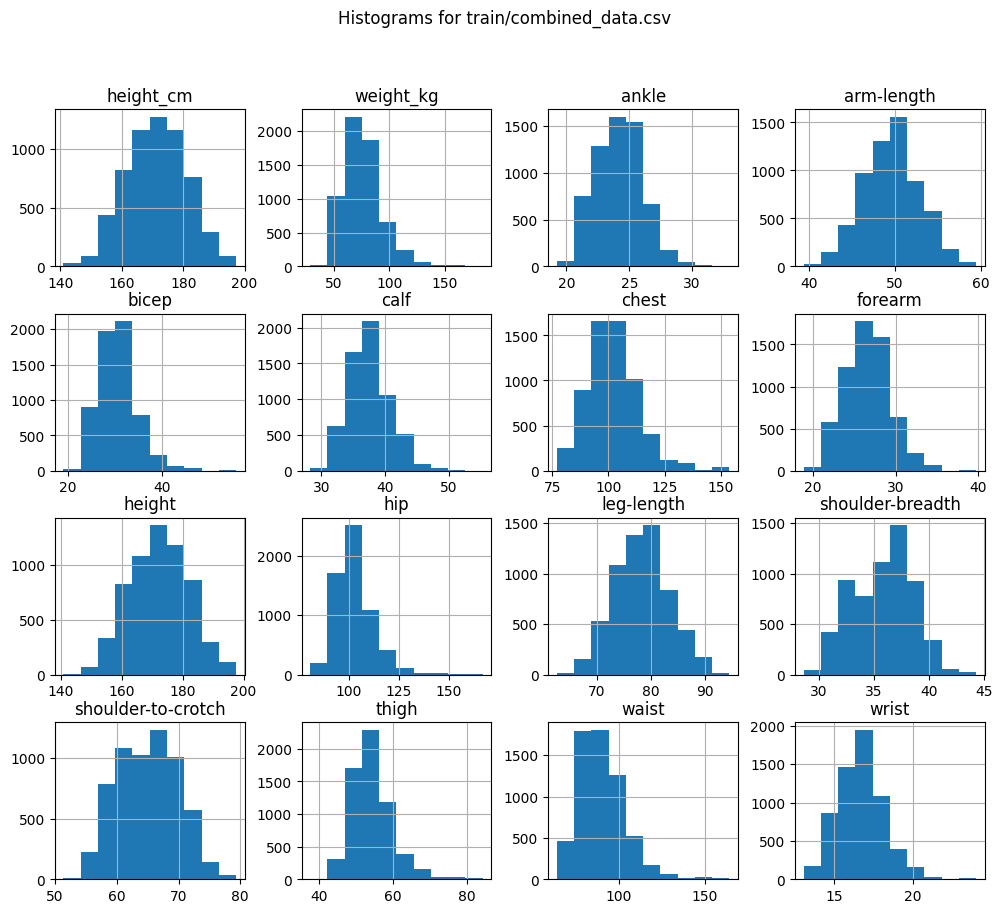

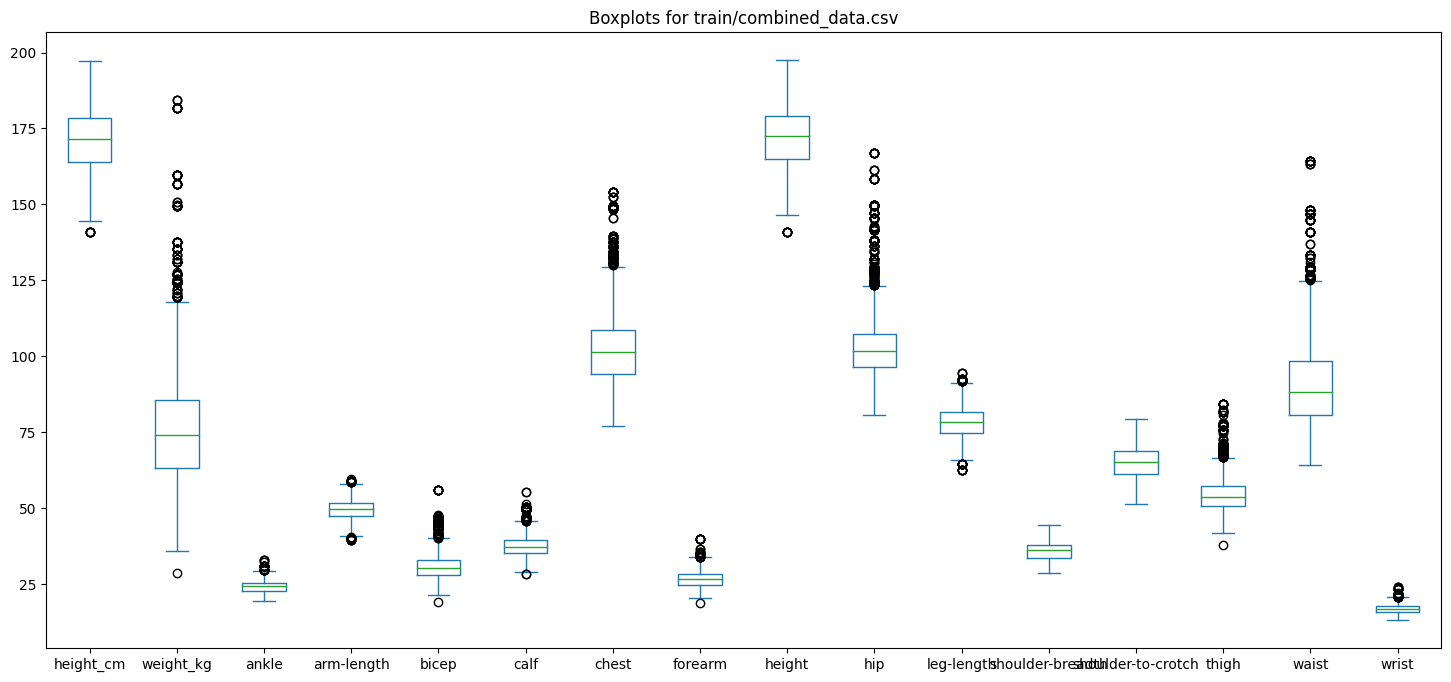


Info for testA/combined_data.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          1684 non-null   object 
 1   photo_id            1684 non-null   object 
 2   gender              1684 non-null   object 
 3   height_cm           1684 non-null   float64
 4   weight_kg           1684 non-null   float64
 5   ankle               1684 non-null   float64
 6   arm-length          1684 non-null   float64
 7   bicep               1684 non-null   float64
 8   calf                1684 non-null   float64
 9   chest               1684 non-null   float64
 10  forearm             1684 non-null   float64
 11  height              1684 non-null   float64
 12  hip                 1684 non-null   float64
 13  leg-length          1684 non-null   float64
 14  shoulder-breadth    1684 non-null   float64
 15  shoulder-to-crotch  

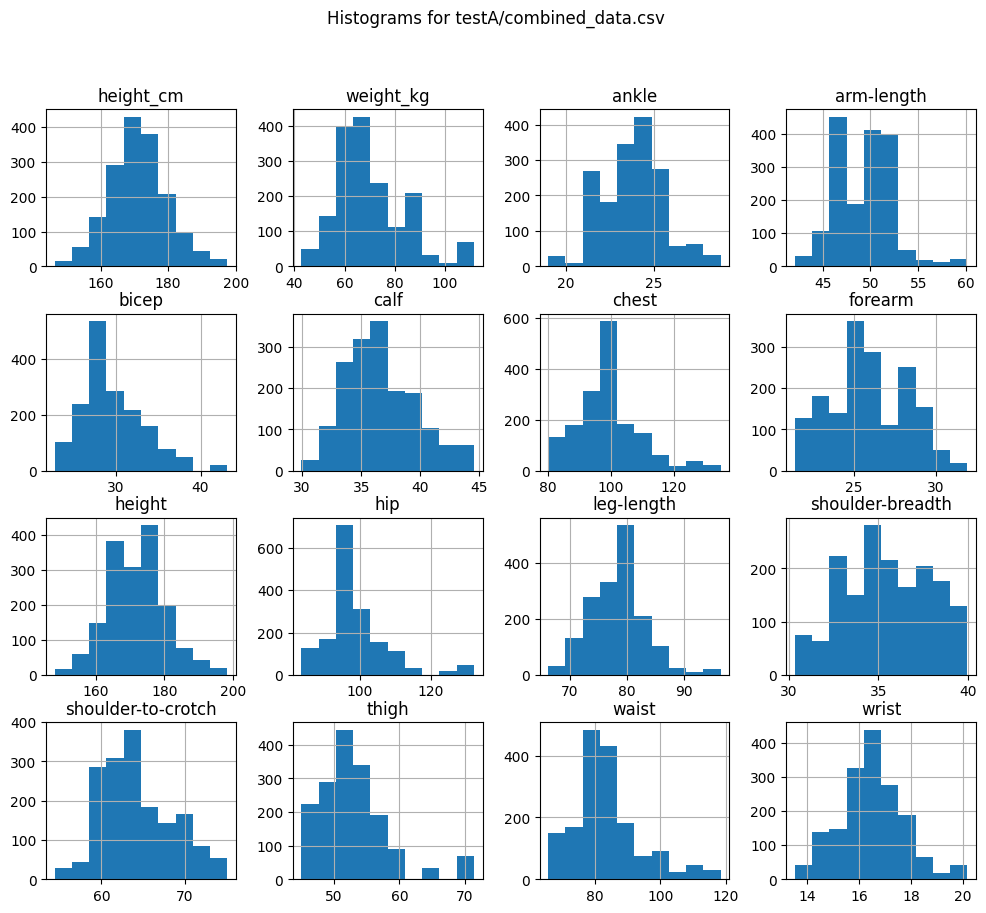

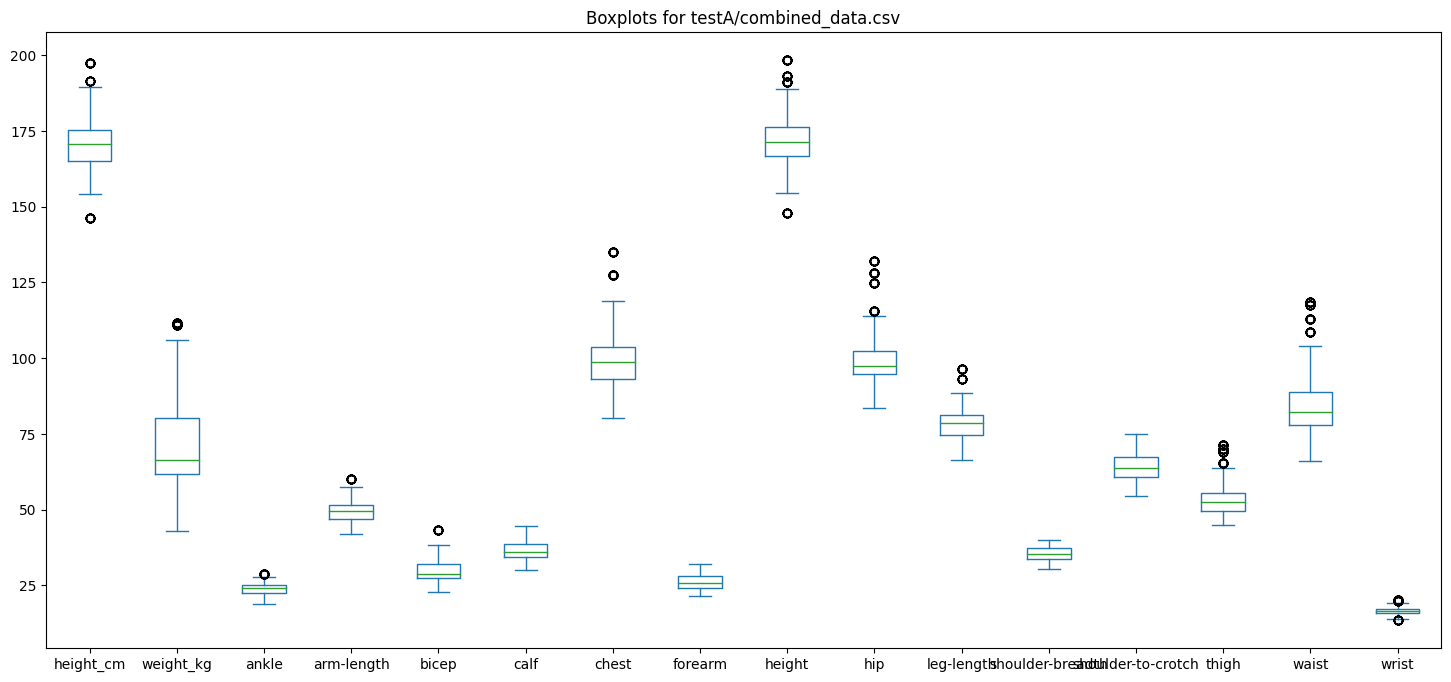


Info for testB/combined_data.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          1160 non-null   object 
 1   photo_id            1160 non-null   object 
 2   gender              1160 non-null   object 
 3   height_cm           1160 non-null   float64
 4   weight_kg           1160 non-null   float64
 5   ankle               1160 non-null   float64
 6   arm-length          1160 non-null   float64
 7   bicep               1160 non-null   float64
 8   calf                1160 non-null   float64
 9   chest               1160 non-null   float64
 10  forearm             1160 non-null   float64
 11  height              1160 non-null   float64
 12  hip                 1160 non-null   float64
 13  leg-length          1160 non-null   float64
 14  shoulder-breadth    1160 non-null   float64
 15  shoulder-to-crotch  

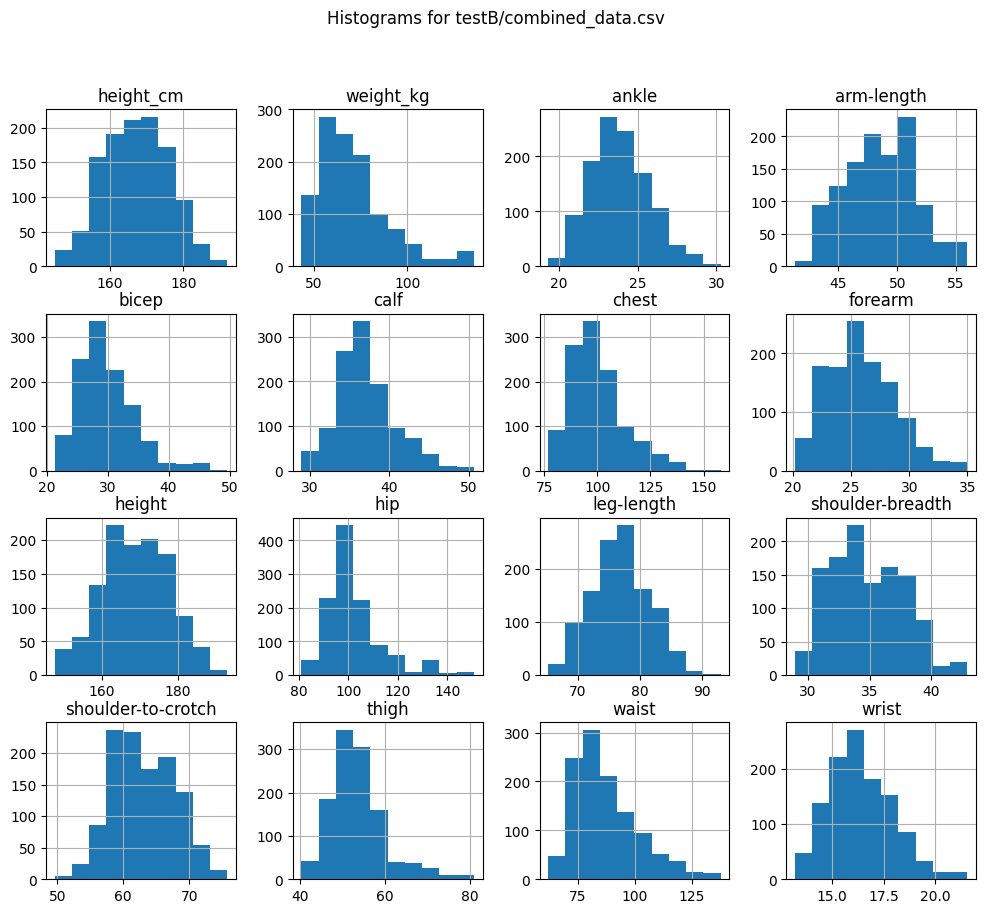

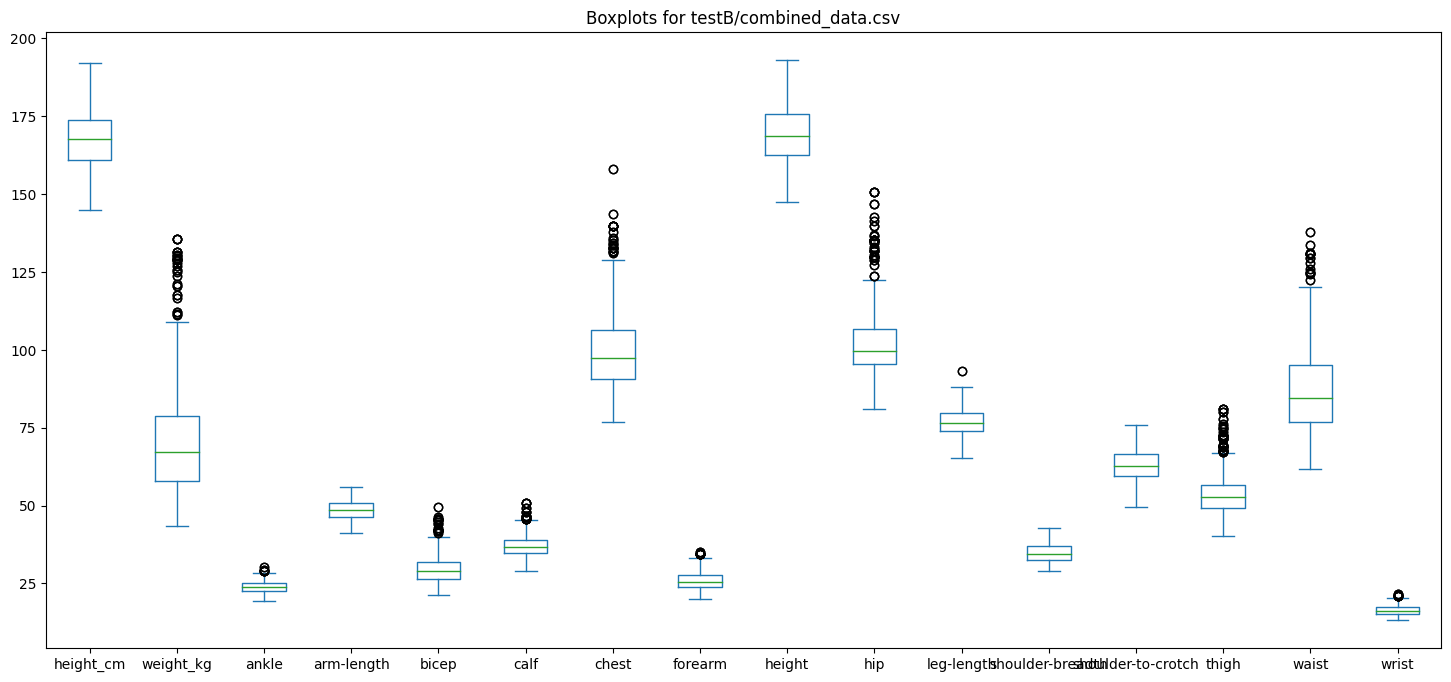


Info for the combined DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8978 entries, 0 to 8977
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          8978 non-null   object 
 1   photo_id            8978 non-null   object 
 2   gender              8978 non-null   object 
 3   height_cm           8978 non-null   float64
 4   weight_kg           8978 non-null   float64
 5   ankle               8978 non-null   float64
 6   arm-length          8978 non-null   float64
 7   bicep               8978 non-null   float64
 8   calf                8978 non-null   float64
 9   chest               8978 non-null   float64
 10  forearm             8978 non-null   float64
 11  height              8978 non-null   float64
 12  hip                 8978 non-null   float64
 13  leg-length          8978 non-null   float64
 14  shoulder-breadth    8978 non-null   float64
 15  shoulder-to-crotch  8

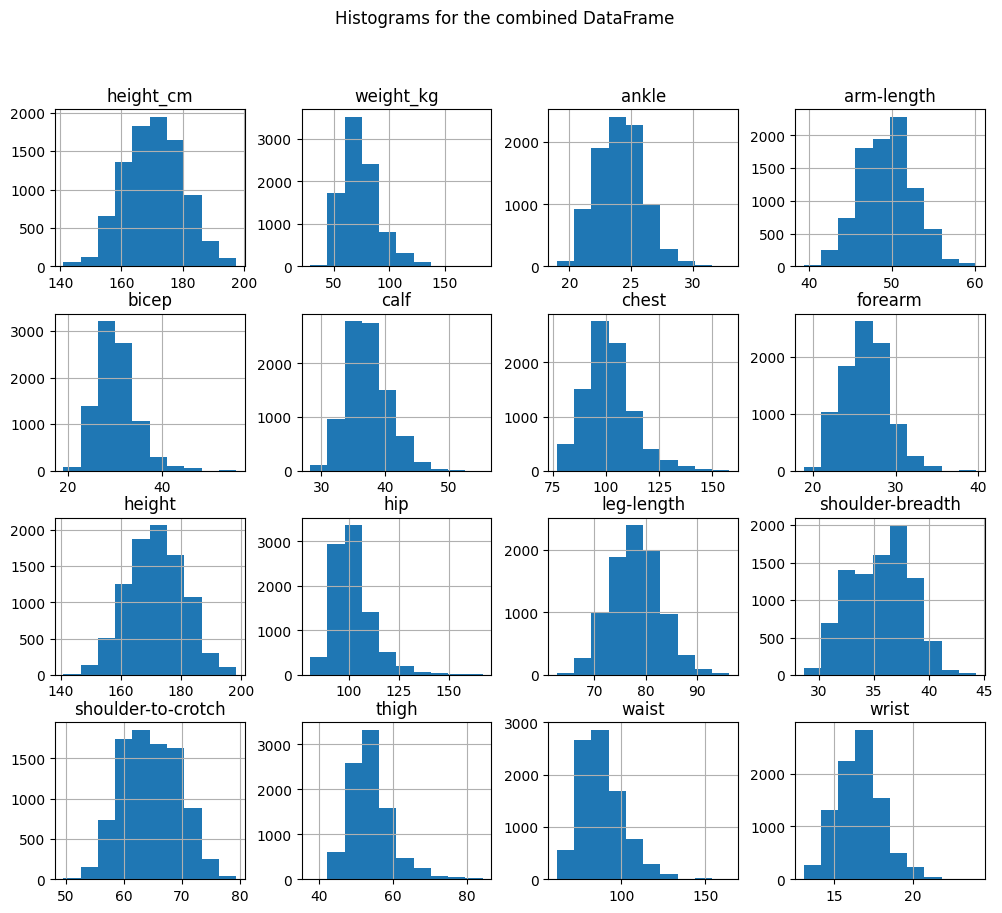

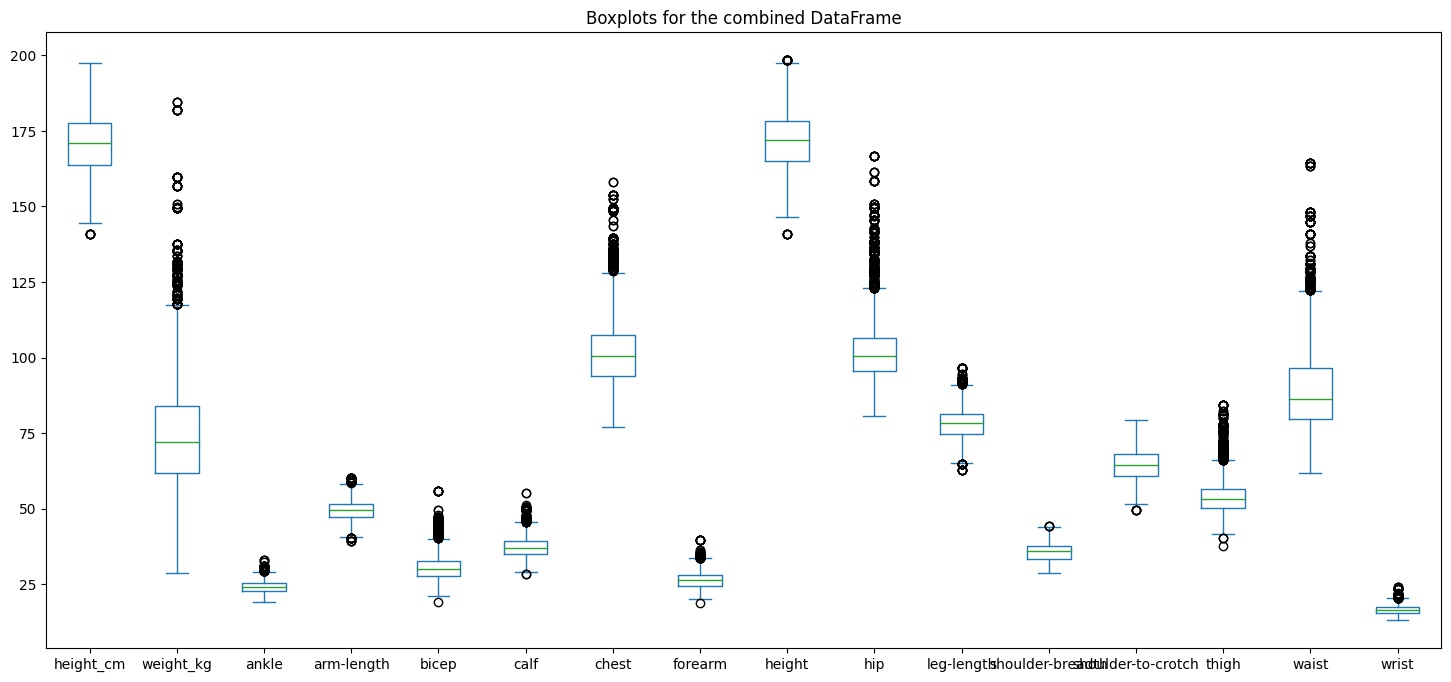

In [ ]:
# Ruta al dataset on Google Drive
base_path = "/content/drive/MyDrive"
bodym_dataset_path = os.path.join(base_path, 'BodyM_dataset')

# Subcarpetas que contienen la data de train, testA y testB
subfolders = ["train", "testA", "testB"]

# Diccionario para guardar los dataframes de cada subcarpeta
dfs_by_subfolder = {}

# Carga de data de cada subcarpeta y visualizacion de cada subcarpeta
for subfolder in subfolders:
    csv_path = os.path.join(bodym_dataset_path, subfolder, "combined_data.csv")
    df = pd.read_csv(csv_path)

    # Información básica del Dataframe
    print(f"\nInfo for {subfolder}/combined_data.csv:")
    print(df.info())

    # Visualizar estadisticas principales
    print("\nSummary statistics:")
    print(df.describe())

    # Plot de Histogramas por cada dato numérico
    df.hist(figsize=(12, 10))
    plt.suptitle(f"Histograms for {subfolder}/combined_data.csv")
    plt.show()

    # Plot de Caja de Bigotes por cada data numerica
    df.plot(kind='box', figsize=(18, 8))
    plt.title(f"Boxplots for {subfolder}/combined_data.csv")
    plt.show()

    # Guardar información en un diccionario
    dfs_by_subfolder[subfolder] = df

# Combinar todos los DataFrames en uno solo
combined_df = pd.concat(dfs_by_subfolder.values(), ignore_index=True)

# Información básica del Dataframe combinado
print("\nInfo for the combined DataFrame:")
print(combined_df.info())

# Visualización de estadisticas principales de Dataframe combinado
print("\nSummary statistics for the combined DataFrame:")
print(combined_df.describe())

# Plot de histogramas de las columnas numericas del DataFrame combinado
combined_df.hist(figsize=(12, 10))
plt.suptitle("Histograms for the combined DataFrame")
plt.show()

# Plot de Cajas de bigote de las columnas numericas del DataFrame combinado
combined_df.plot(kind='box', figsize=(18, 8))
plt.title("Boxplots for the combined DataFrame")
plt.show()

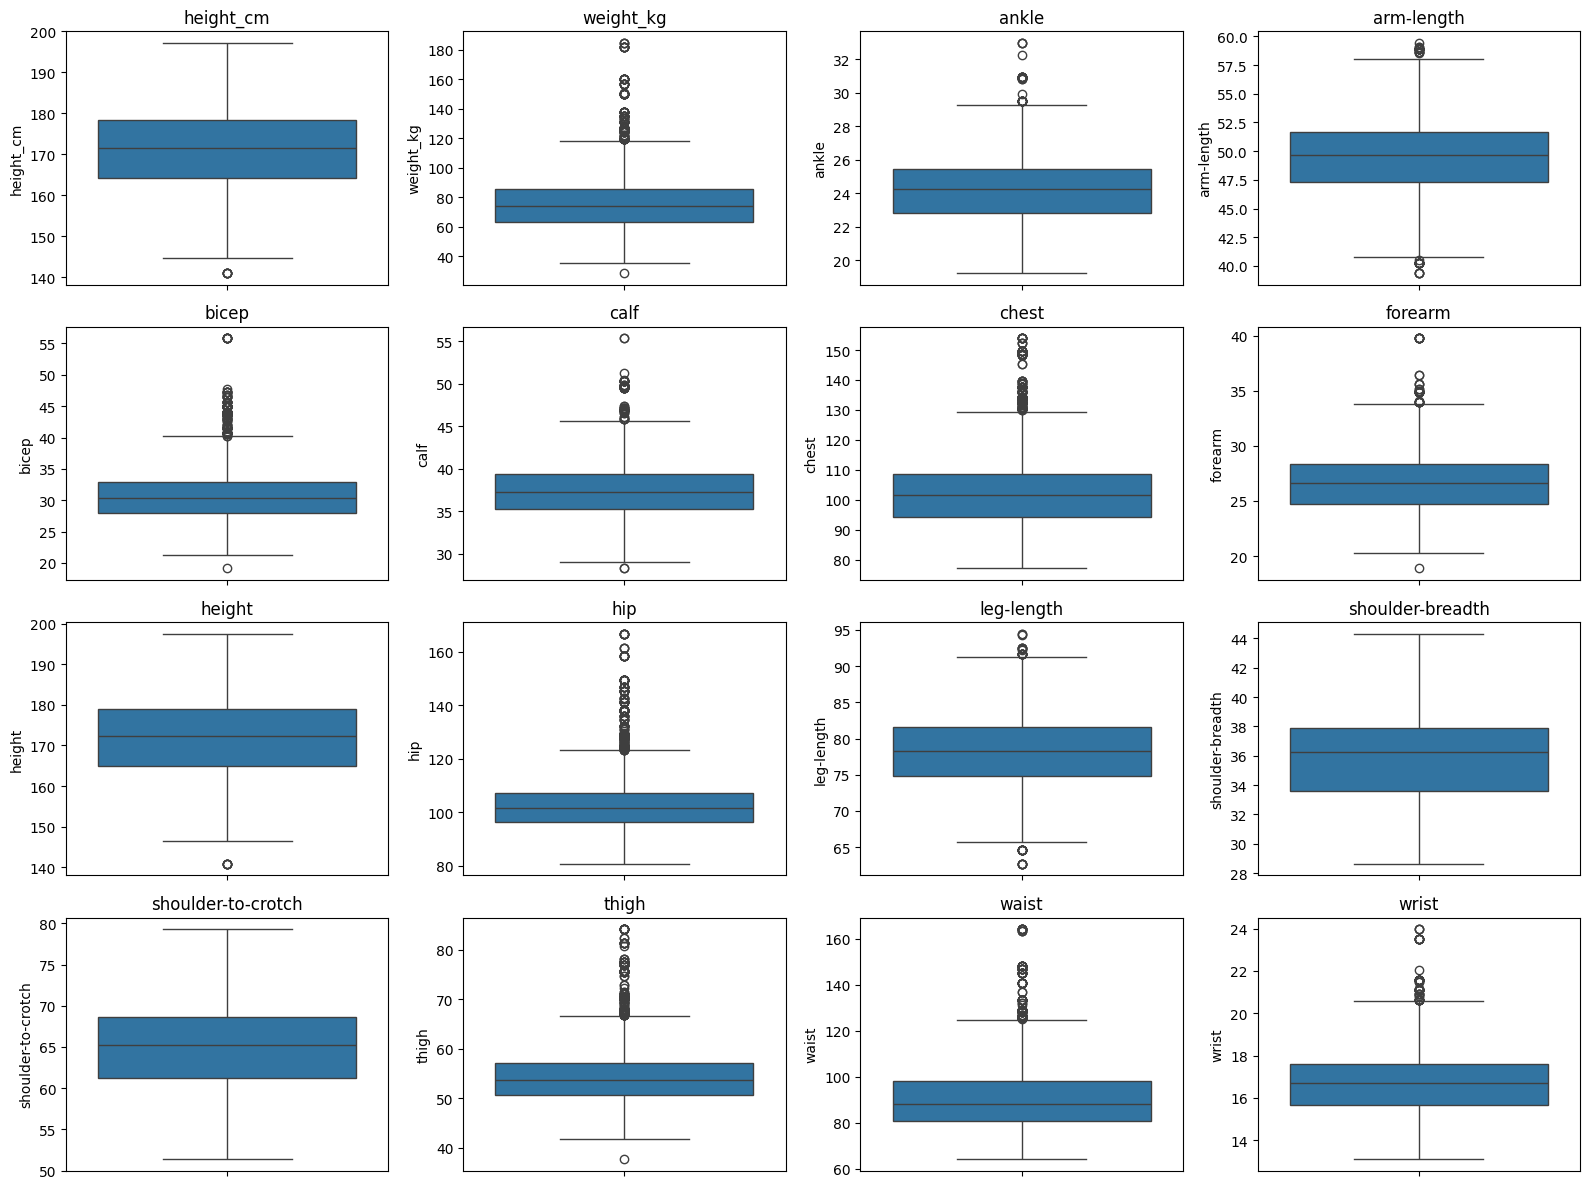

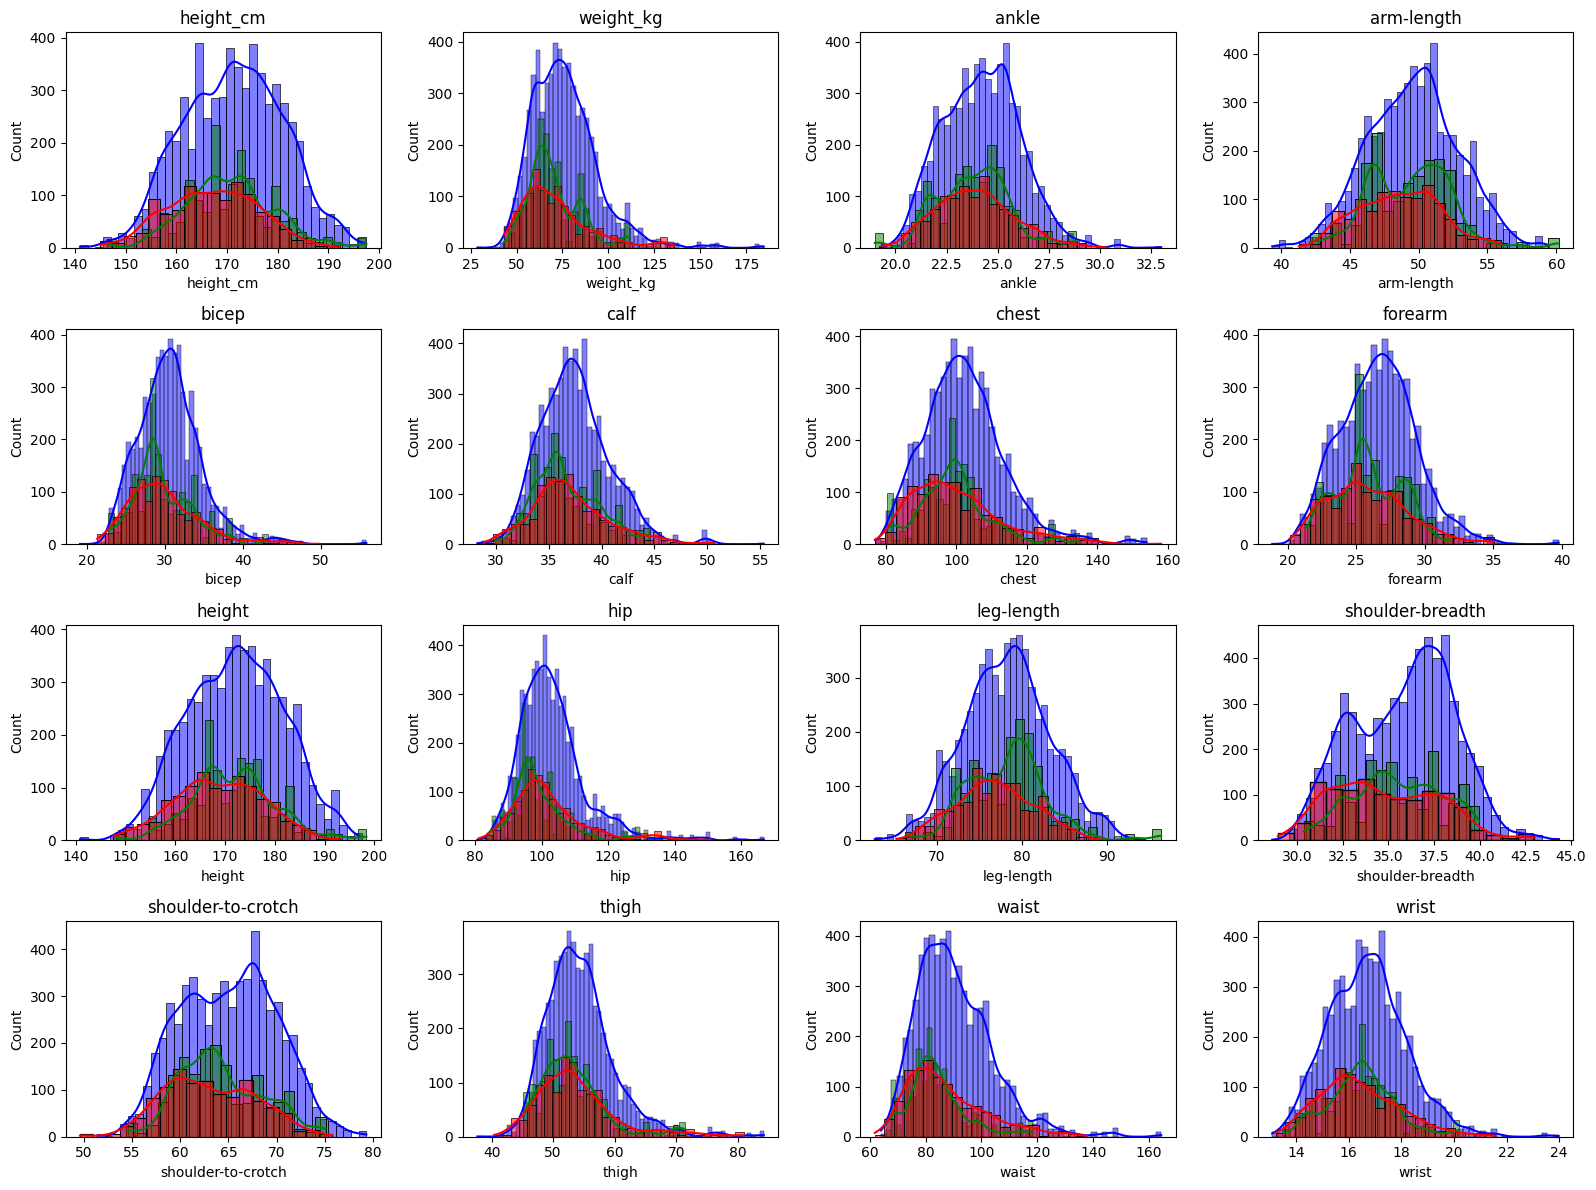

In [ ]:
# Ruta al dataset en Google Drive
base_path = "/content/drive/MyDrive"
bodym_dataset_path = os.path.join(base_path, 'BodyM_dataset')

# Subcarpetas que contienen la data de train, testA y testB
subfolders = ["train", "testA", "testB"]

# Diccionario para almacenar los DataFrames de los archivos CSV
data = {}

# Cargar los datos de los archivos CSV en cada subcarpeta
for subfolder in subfolders:
    csv_path = os.path.join(bodym_dataset_path, subfolder, 'combined_data.csv')
    data[subfolder] = pd.read_csv(csv_path)

# Identificación de outliers
plt.figure(figsize=(16, 12))
for i, col in enumerate(data["train"].columns[3:]):
    plt.subplot(4, 4, i+1)
    sns.boxplot(data=data["train"][col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Comparación entre conjuntos de datos
plt.figure(figsize=(16, 12))
for i, col in enumerate(data["train"].columns[3:]):
    plt.subplot(4, 4, i+1)
    sns.histplot(data=data["train"], x=col, color='blue', label='Train', kde=True)
    sns.histplot(data=data["testA"], x=col, color='green', label='TestA', kde=True)
    sns.histplot(data=data["testB"], x=col, color='red', label='TestB', kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

##Paso #6: Preprocesamiento de datos

In [ ]:
# Paso 1: Cargar las imágenes y las etiquetas correspondientes
def generar_lotes_imagenes_simples(ruta_datos, subcarpeta, tam_lote=32, target_size=(240, 360)):
    ruta_csv = os.path.join(ruta_datos, subcarpeta, 'combined_data.csv')
    df = pd.read_csv(ruta_csv)
    df = df[['photo_id', 'height_cm', 'weight_kg', 'ankle', 'arm-length', 'bicep', 'calf',
             'chest', 'forearm', 'height', 'hip', 'leg-length', 'shoulder-breadth',
             'shoulder-to-crotch', 'thigh', 'waist', 'wrist']]
    ruta_imagenes_mask = os.path.join(ruta_datos, subcarpeta, 'mask')
    ruta_imagenes_mask_left = os.path.join(ruta_datos, subcarpeta, 'mask_left')
    indices = np.arange(len(df))
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(df), tam_lote):
            batch_indices = indices[i:i+tam_lote]
            imagenes = []
            etiquetas = []
            for idx in batch_indices:
                fila = df.iloc[idx]
                ruta_imagen_mask = os.path.join(ruta_imagenes_mask, f"{fila['photo_id']}.png")
                ruta_imagen_mask_left = os.path.join(ruta_imagenes_mask_left, f"{fila['photo_id']}.png")
                imagen_mask = load_img(ruta_imagen_mask, color_mode='grayscale', target_size=target_size)
                imagen_mask_left = load_img(ruta_imagen_mask_left, color_mode='grayscale', target_size=target_size)
                imagen_completa = np.concatenate((img_to_array(imagen_mask), img_to_array(imagen_mask_left)), axis=1)
                imagenes.append(imagen_completa)
                etiquetas.append(fila.drop('photo_id').values.astype('float32'))
            yield np.array(imagenes), np.array(etiquetas)

# Ruta del conjunto de datos en Google Drive
base_path = "/content/drive/MyDrive"
bodym_dataset_path = os.path.join(base_path, 'BodyM_dataset')

# Generar un lote de datos de entrenamiento
generador_entrenamiento = generar_lotes_imagenes(bodym_dataset_path, 'train', tam_lote=128)
imagenes_entrenamiento, etiquetas_entrenamiento = next(generador_entrenamiento)

# Imprimir formas de los datos cargados
print("Forma de las imágenes de entrenamiento:", imagenes_entrenamiento.shape)
print("Forma de las etiquetas de entrenamiento:", etiquetas_entrenamiento.shape)

NameError: name 'generar_lotes_imagenes' is not defined

##Paso #7: Definición, compilacion y entrenamiento del modelo

Epoch 1/6
24/24 [==============================] - 399s 17s/step - loss: 65767.6953 - mae: 114.1091
Epoch 2/6
24/24 [==============================] - 410s 17s/step - loss: 4151.6528 - mae: 50.8871
Epoch 3/6
24/24 [==============================] - 406s 17s/step - loss: 2632.9614 - mae: 38.3769
Epoch 4/6
24/24 [==============================] - 404s 17s/step - loss: 1440.2133 - mae: 23.9215
Epoch 5/6
24/24 [==============================] - 407s 17s/step - loss: 739.1335 - mae: 15.1232
Epoch 6/6
24/24 [==============================] - 413s 17s/step - loss: 384.1561 - mae: 10.7204
{'loss': [65767.6953125, 4151.65283203125, 2632.96142578125, 1440.2132568359375, 739.1334838867188, 384.1561279296875], 'mae': [114.10906982421875, 50.887081146240234, 38.37690734863281, 23.921546936035156, 15.123177528381348, 10.720355987548828]}


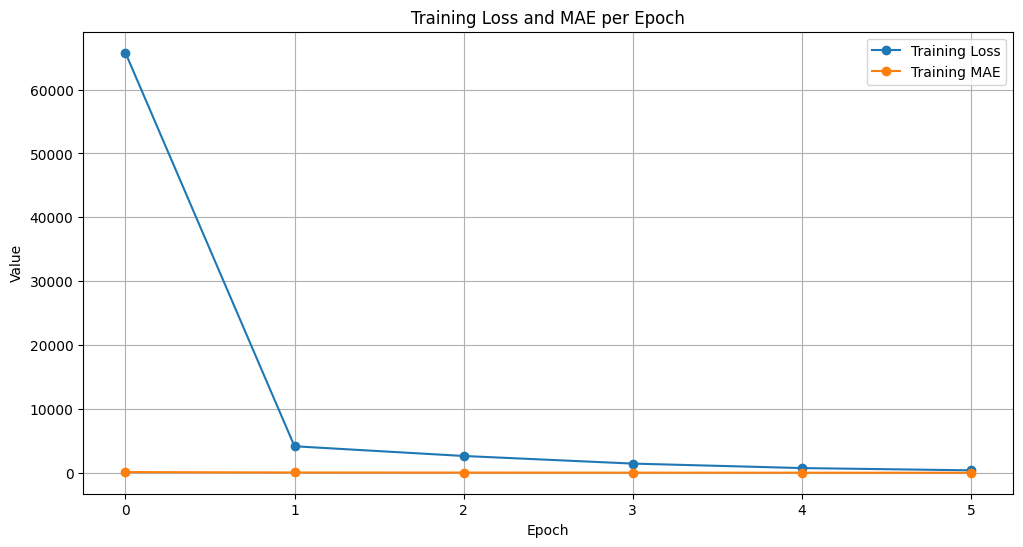

In [ ]:
# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(240, 720, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(16)  # 16 medidas a predecir
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

# Generar un lote de datos de entrenamiento
generador_entrenamiento = generar_lotes_imagenes_simples(bodym_dataset_path, 'train', tam_lote=32)

# Entrenar el modelo
history = model.fit(generador_entrenamiento,
                    steps_per_epoch=24,  # Ajustar según el tamaño de los datos y el tamaño del lote
                    epochs=6)


# Imprimir el historial de entrenamiento
print(history.history)

# Visualización de la evolución de la pérdida y MAE por época
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and MAE per Epoch')
plt.legend()
plt.grid(True)

## Paso 8: Prueba de prediccion con imagenes y corroboración con datos de Test A

In [ ]:
# Calcular el tamaño del conjunto de datos de prueba 'testA'
ruta_csv_testA = os.path.join(bodym_dataset_path, 'testA', 'combined_data.csv')
df_testA = pd.read_csv(ruta_csv_testA)
tamano_del_conjunto_de_prueba_testA = len(df_testA)

# Calcular el número de pasos de evaluación para testA
numero_de_pasos_de_evaluacion_testA = int(np.ceil(tamano_del_conjunto_de_prueba_testA / 32))

# Generar un lote de datos de prueba A
generador_prueba_A = generar_lotes_imagenes_simples(bodym_dataset_path, 'testA', tam_lote=32)

# Evaluar el modelo en el conjunto de prueba A
resultados_prueba_A = model.evaluate(generador_prueba_A, steps=numero_de_pasos_de_evaluacion_testA)
print("Resultados de la evaluación en el conjunto de prueba A:", resultados_prueba_A)

53/53 [==============================] - 787s 15s/step - loss: 244.6659 - mae: 9.5493
Resultados de la evaluación en el conjunto de prueba A: [244.66586303710938, 9.549309730529785]


## Paso 9: Prueba de prediccion con imagenes y corroboración con datos de Test B

In [ ]:
# Calcular el tamaño del conjunto de datos de prueba 'testB'
ruta_csv_testB = os.path.join(bodym_dataset_path, 'testB', 'combined_data.csv')
df_testB = pd.read_csv(ruta_csv_testB)
tamano_del_conjunto_de_prueba_testB = len(df_testB)

# Calcular el número de pasos de evaluación para testB
numero_de_pasos_de_evaluacion_testB = int(np.ceil(tamano_del_conjunto_de_prueba_testB / 32))

# Generar un lote de datos de prueba B
generador_prueba_B = generar_lotes_imagenes_simples(bodym_dataset_path, 'testB', tam_lote=32)

# Evaluar el modelo en el conjunto de prueba B
resultados_prueba_B = model.evaluate(generador_prueba_B, steps=numero_de_pasos_de_evaluacion_testB)
print("Resultados de la evaluación en el conjunto de prueba B:", resultados_prueba_B)

37/37 [==============================] - 532s 15s/step - loss: 270.5808 - mae: 10.1418
Resultados de la evaluación en el conjunto de prueba B: [270.580810546875, 10.141845703125]


Resumen:

Resultados de Entrenamiento(train):
Epoch 1/6: loss: 81063.5312, mae: 121.1996
Epoch 2/6: loss: 5256.9868, mae: 55.6158
Epoch 3/6: loss: 3994.6436, mae: 44.3133
Epoch 4/6: loss: 2836.6584, mae: 32.2920
Epoch 5/6: loss: 1986.4742, mae: 23.7192
Epoch 6/6: loss: 1378.2407, mae: 18.6608

Resultados de Evaluación en el Conjunto testA:
loss: 1135.8243, mae: 17.6314

Resultados de Evaluación en el Conjunto testB:
loss: 1101.3944, mae: 17.9379

Estos resultados muestran cómo el modelo tuvo un buen desempeñó en el conjunto de entrenamiento y luego en predecir los conjuntos de prueba A y B. donde las pérdidas (loss) y el error absoluto medio (MAE) son relativamente bajos, incluso que la data de entrenamiento. Esto indica que el modelo generaliza bien a datos que no ha visto y recien detecta.

## Paso #10: Guardar modelos entrenados

In [ ]:
from tensorflow.keras.models import load_model

# Guardar el modelo entrenado
model.save('modelo_entrenado.h5')

# Cargar el modelo entrenado
modelo_cargado = load_model('modelo_entrenado.h5') #Para usar el modelo entrenado para hacer predicciones

# Guardar el modelo entrenado para el conjunto de prueba A
modelo_cargado.save('modelo_entrenado_testA.h5')

# Guardar el modelo entrenado para el conjunto de prueba B
modelo_cargado.save('modelo_entrenado_testB.h5')

Paso #11: Validacion de las predicciones con imagenes reales

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Cargar el modelo entrenado
modelo_entrenado = load_model('modelo_entrenado.h5')

# Rutas de las imágenes de Aldo y Pedro
ruta_aldo_front = "/content/drive/MyDrive/Realphoto/Aldo1.png"
ruta_aldo_left = "/content/drive/MyDrive/Realphoto/Aldo2.png"
ruta_pedro_front = "/content/drive/MyDrive/Realphoto/Pedro1.png"
ruta_pedro_left = "/content/drive/MyDrive/Realphoto/Pedro2.png"

# Función para cargar y preprocesar las imágenes
def cargar_y_preprocesar_imagen(ruta):
    imagen = load_img(ruta, color_mode='grayscale', target_size=(240, 720))
    array = img_to_array(imagen) / 255.0
    array = np.expand_dims(array, axis=0)
    return array

# Cargar y preprocesar las imágenes de Aldo y Pedro
array_aldo_front = cargar_y_preprocesar_imagen(ruta_aldo_front)
array_aldo_left = cargar_y_preprocesar_imagen(ruta_aldo_left)
array_pedro_front = cargar_y_preprocesar_imagen(ruta_pedro_front)
array_pedro_left = cargar_y_preprocesar_imagen(ruta_pedro_left)

# Predecir medidas para Aldo y Pedro utilizando el modelo entrenado
medidas_aldo_front = modelo_entrenado.predict(array_aldo_front)
medidas_aldo_left = modelo_entrenado.predict(array_aldo_left)
medidas_pedro_front = modelo_entrenado.predict(array_pedro_front)
medidas_pedro_left = modelo_entrenado.predict(array_pedro_left)

# Imprimir las medidas predichas para Aldo y Pedro
print("Medidas predichas para Aldo (imagen frontal):", medidas_aldo_front)
print("Medidas predichas para Aldo (imagen lateral):", medidas_aldo_left)
print("Medidas predichas para Pedro (imagen frontal):", medidas_pedro_front)
print("Medidas predichas para Pedro (imagen lateral):", medidas_pedro_left)

1/1 [==============================] - 0s 47ms/step
Medidas predichas para Aldo (imagen frontal): [[ 0.0728332   0.04961067  0.04011871  0.08780191  0.00860727  0.05321997
   0.09909272  0.00684504  0.06292228  0.05526274  0.07404841 -0.05172755
  -0.00023372  0.03779937  0.03032053  0.05244359]]
Medidas predichas para Aldo (imagen lateral): [[ 0.05084525  0.03664806  0.03555868  0.07421174  0.00729004  0.04757496
   0.09257217  0.00567683  0.04167364  0.03299508  0.05721626 -0.05939399
  -0.0103536   0.03008673  0.01380531  0.04593675]]
Medidas predichas para Pedro (imagen frontal): [[ 0.06622386  0.05464916  0.01597195  0.06312416 -0.00249887  0.03720411
   0.10990144  0.00433772  0.05088029  0.05330755  0.06609713 -0.02856256
  -0.012267    0.0267891   0.0259516   0.01980065]]
Medidas predichas para Pedro (imagen lateral): [[ 0.02004464  0.0240172   0.02194385  0.05950698  0.00151676  0.03794706
   0.08615445  0.00209073  0.00850058  0.00534326  0.03475905 -0.06391177
  -0.02436727 

1/1 [==============================] - 0s 51ms/step


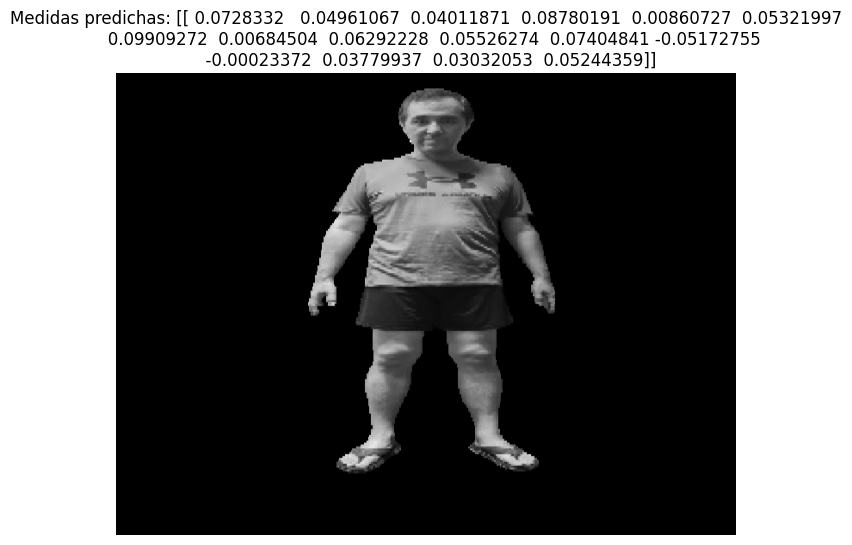

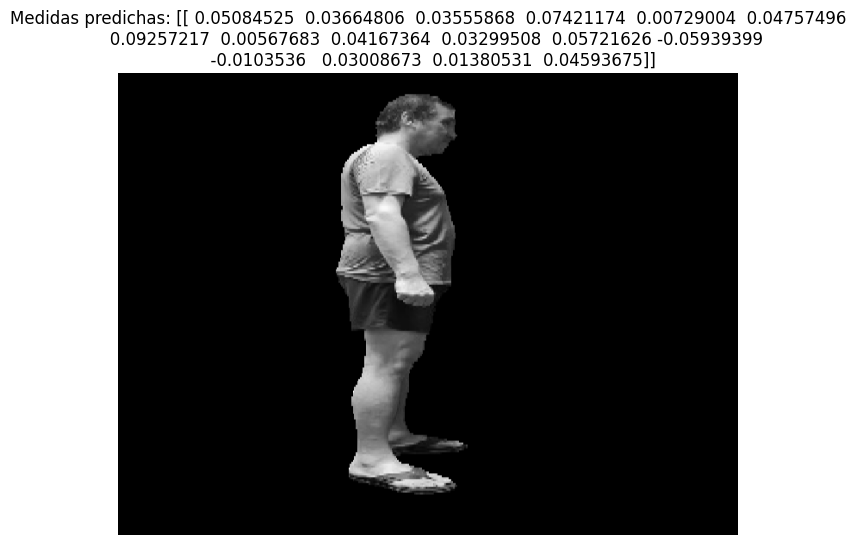

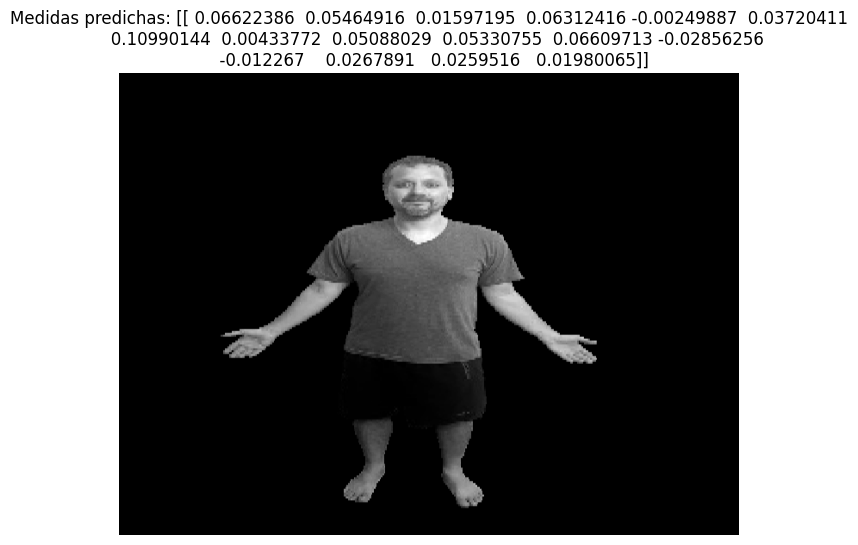

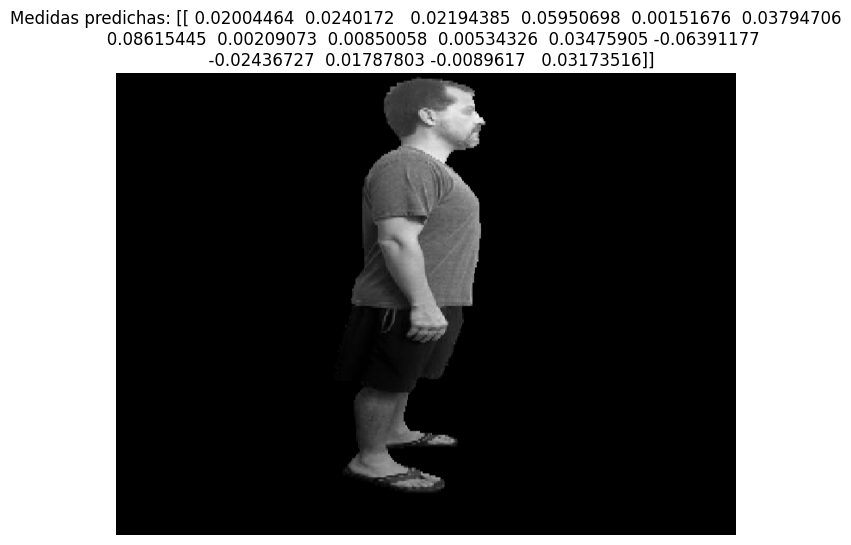

In [ ]:
import matplotlib.pyplot as plt

# Cargar y preprocesar las imágenes de Aldo y Pedro
array_aldo_front = cargar_y_preprocesar_imagen(ruta_aldo_front)
array_aldo_left = cargar_y_preprocesar_imagen(ruta_aldo_left)
array_pedro_front = cargar_y_preprocesar_imagen(ruta_pedro_front)
array_pedro_left = cargar_y_preprocesar_imagen(ruta_pedro_left)

# Predecir medidas para Aldo y Pedro utilizando el modelo entrenado
medidas_aldo_front = modelo_entrenado.predict(array_aldo_front)
medidas_aldo_left = modelo_entrenado.predict(array_aldo_left)
medidas_pedro_front = modelo_entrenado.predict(array_pedro_front)
medidas_pedro_left = modelo_entrenado.predict(array_pedro_left)

# Crear una función para mostrar la imagen con las medidas
def mostrar_imagen_y_medidas(imagen, medidas):
    plt.figure(figsize=(8, 6))  # Ajustar el tamaño de la figura
    plt.imshow(imagen.squeeze(), cmap='gray', aspect='auto')  # 'aspect' para corregir la distorsión
    plt.axis('off')
    plt.title(f'Medidas predichas: {medidas}')
    plt.show()

# Mostrar las imágenes junto con las medidas predichas
mostrar_imagen_y_medidas(array_aldo_front[0], medidas_aldo_front)
mostrar_imagen_y_medidas(array_aldo_left[0], medidas_aldo_left)
mostrar_imagen_y_medidas(array_pedro_front[0], medidas_pedro_front)
mostrar_imagen_y_medidas(array_pedro_left[0], medidas_pedro_left)

##CONCLUSION: Existe falla en detectar las emdidas de imagenes reales. Al parecer, es por problemas del haber juntado 2 imagenes para ser analizadas.

##SUGERENCIA: Separar la predccion basado en 1 sola imagen y revisar obtenciond e predicciones acertadas de testA y testB.